In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np
import io_utils

from matplotlib import pyplot as plt
from IPython import display

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.0


In [2]:
if tf.test.gpu_device_name(): 
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [3]:
from configuration import *
# DATASET_SIZE *= NUMBER_OF_DOMAINS
# TRAIN_SIZE *= NUMBER_OF_DOMAINS
# TEST_SIZE *= NUMBER_OF_DOMAINS
# TRAIN_SIZES = [NUMBER_OF_DOMAINS * s for s in TRAIN_SIZES]
# TEST_SIZES = [NUMBER_OF_DOMAINS * s for s in TEST_SIZES]

print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET_SIZE 294
TRAIN_SIZE 250
TEST_SIZE 44


In [4]:
# model = "unpaired-stargan"
model = "paired-stargan"

if model == "unpaired-stargan":
    from dataset_utils import create_unpaired_image_loader as create_image_loader

    train_dataset = tf.data.Dataset.range(TRAIN_SIZE*NUMBER_OF_DOMAINS).shuffle(TRAIN_SIZE*NUMBER_OF_DOMAINS)
    train_dataset = train_dataset.map(create_image_loader(TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE)

    test_dataset = tf.data.Dataset.range(TEST_SIZE*NUMBER_OF_DOMAINS).shuffle(TEST_SIZE*NUMBER_OF_DOMAINS)
    test_dataset = test_dataset.map(create_image_loader(TEST_SIZES, "test", False))
    print(test_dataset)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    # print(test_dataset)
    # for el in test_dataset.take(3):
    #     print(el)
    # test_dataset = test_dataset.unbatch()
    # print(test_dataset)
    # for el in test_dataset.take(3):
    #     print(el)
    
    
elif model == "paired-stargan":
    from dataset_utils import create_paired_star_image_loader as create_image_loader

    train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
    train_dataset = train_dataset.map(create_image_loader(TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE)

    test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)
    test_dataset = test_dataset.map(create_image_loader(TEST_SIZES, "test", False))
    test_dataset = test_dataset.batch(BATCH_SIZE)

In [5]:
def show_example(dataset, side_index = 2):
    example_image, example_domain = next(iter(dataset.take(1)))[side_index]
    example_image = (example_image + 1.0) / 2.0
    
    domain_name = DIRECTION_FOLDERS[side_index]
    
    plt.title(domain_name, fontdict={"fontsize": 12})
    plt.imshow(tf.squeeze(example_image), vmin=0.0, vmax=1.0)
    plt.axis("off")

# show_example(test_dataset)

In [6]:
from stargan_model import StarGANModel, PairedStarGANModel

if model == "unpaired-stargan":
    model = StarGANModel(train_dataset, test_dataset, "unpaired", "stargan-rpgmakerxp", discriminator_steps=5, lambda_domain=1.)
elif model == "paired-stargan":
    model = PairedStarGANModel(train_dataset, test_dataset, "paired-playground", "stargan-rpgmakerxp", discriminator_steps=5, lambda_domain=1.)

In [7]:
# print("Generator:")
# model.generator.summary()
# print("Discriminator:")
# model.discriminator.summary()

Time since start: 03m:42s
Estimated time to finish: 00m:01s
Last 100 steps took: 98.99s



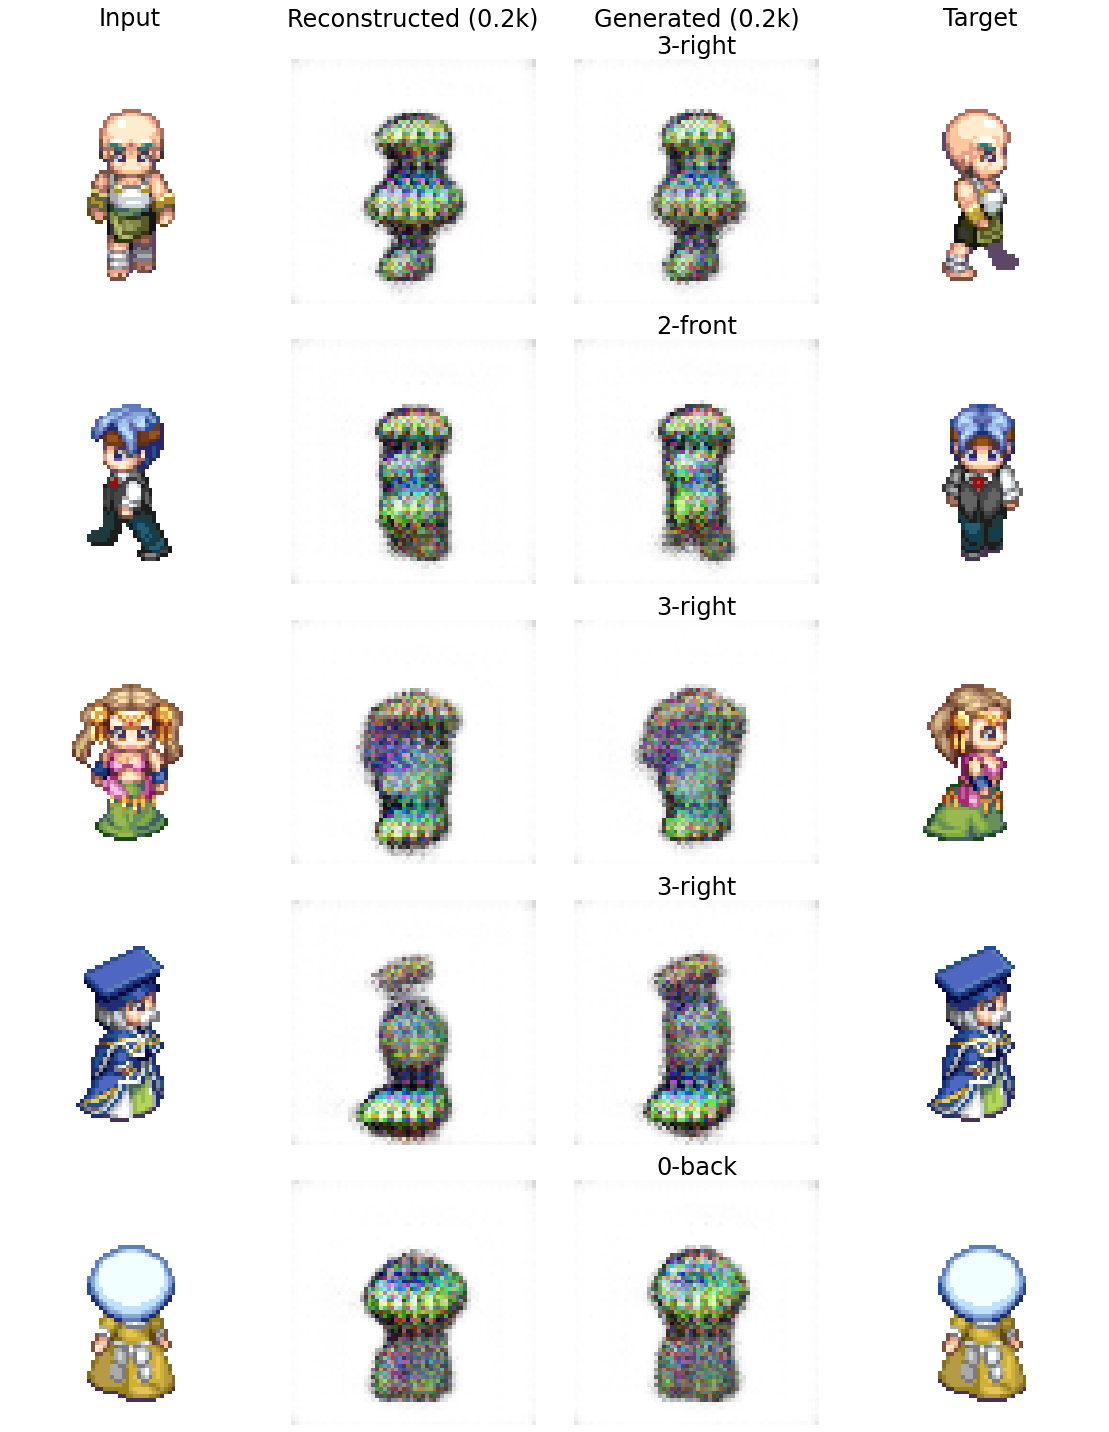

Calculating Fréchet Inception Distance at 0.2k with 44 test examples... FID: 33.32187
Showing discriminator patches


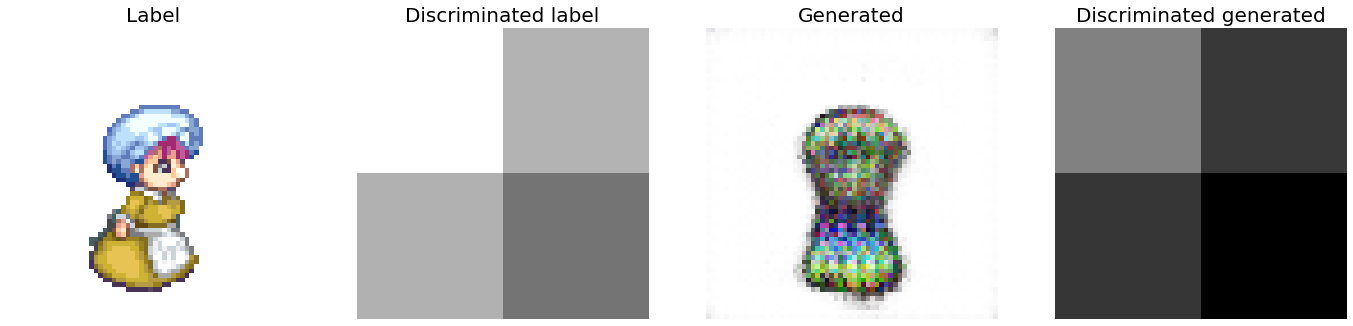

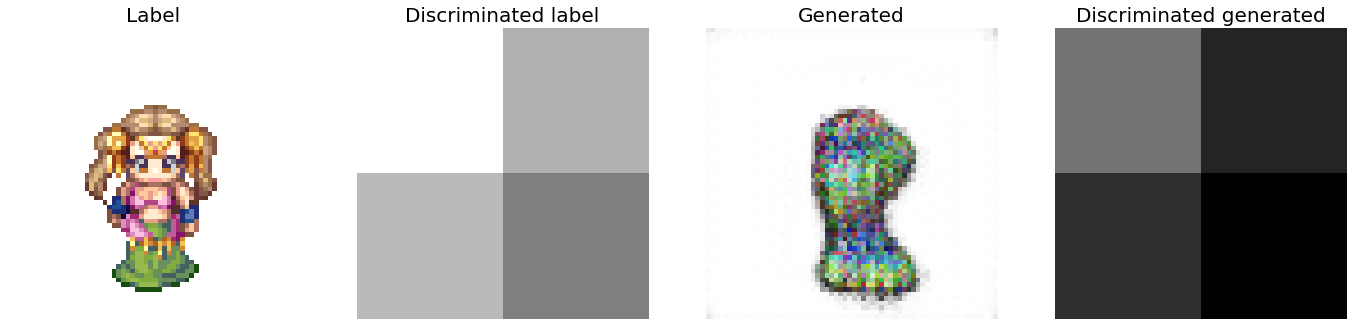

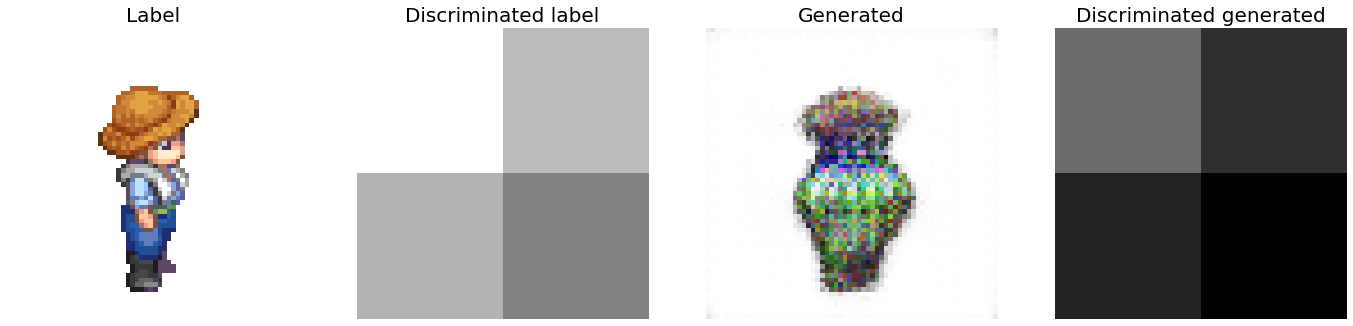

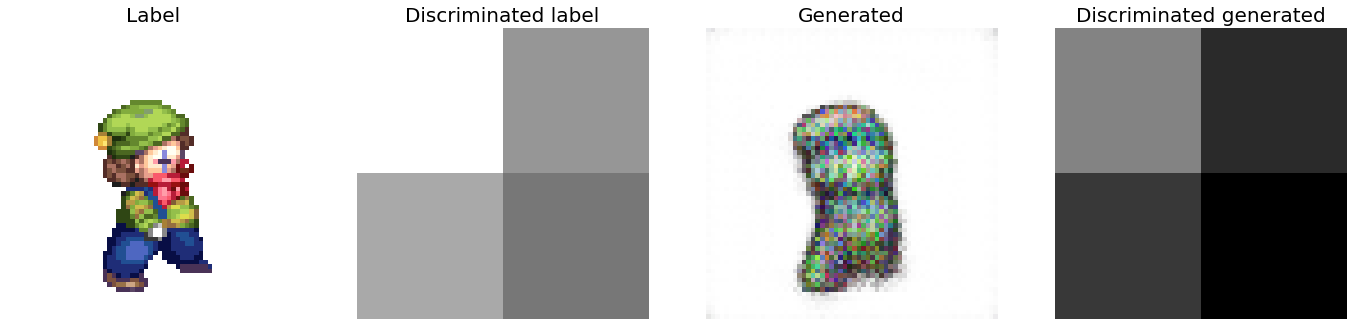

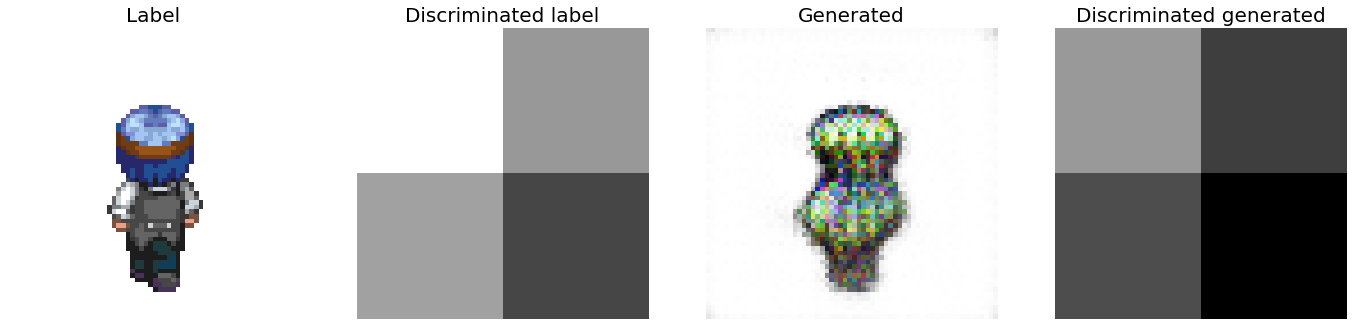

Step: 0.2k


In [8]:
STEPS = 200
UPDATE_STEPS = 100

print("Starting training...")
model.fit(STEPS, UPDATE_STEPS, callbacks=["fid", "show_patches"])